# Image Classification with DNN

## DATASETS:
(a) Carbonic Anhydrase II (ChEMBL205), a protein lyase,  
(b) Cyclin-dependent kinase 2 (CHEMBL301), a protein kinase,  
(c) ether-a-go-go-related gene potassium channel 1 (HERG) (CHEMBL240), a voltage-gated ion channel,  
(d) Dopamine D4 receptor (CHEMBL219), a monoamine GPCR,  
(e) Coagulation factor X (CHEMBL244), a serine protease,  
(f) Cannabinoid CB1 receptor (CHEMBL218), a lipid-like GPCR and  
(g) Cytochrome P450 19A1 (CHEMBL1978), a cytochrome P450.  
The activity classes were selected based on data availability and as representatives of therapeutically important target classes or as anti-targets.

In [1]:
!nvidia-smi

Fri Apr 23 07:51:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 450.36.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro P5000        On   | 00000000:00:05.0 Off |                  Off |
| 26%   21C    P8     5W / 180W |      1MiB / 16278MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [10]:
%%capture
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit

In [2]:
# Import
import pandas as pd
import numpy as np
from pathlib import Path

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import os
sys.path.append('/usr/local/lib/python3.7/site-packages/')
from rdkit import Chem
from rdkit.Chem import AllChem

In [77]:
dataset = 'CHEMBL205_cl'

In [78]:
path = Path('../dataset/13321_2017_226_MOESM1_ESM/')
df = pd.read_csv(path/f'{dataset}.csv')

In [6]:
list(path.iterdir())

[PosixPath('../dataset/13321_2017_226_MOESM1_ESM/RdkitDescriptors.py'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL205_cl_ecfp_1024.csv'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL218_cl.csv'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL205_cl.csv'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL1978_cl.csv'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL244_cl.csv'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL240_cl.csv'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL301_cl.csv'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL219_cl.csv'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/.ipynb_checkpoints'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/mol_images'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL218_cl_ecfp_1024.csv')]

# Generate images

In [7]:
DATA = path/'mol_images'
DATA.mkdir(exist_ok=True)

In [79]:
df.head()

,CID,SMILES,Activity
0,CHEMBL188002,S(=O)(=O)(N)c1cc(N/C(/S)=N\c2cc(C(=O)[O-])c(cc2)C=2c3c(OC4=CC(=O)C=CC=24)cc(O)cc3)ccc1,1
1,CHEMBL364127,Clc1ccc(cc1)C(=O)NC1Cc2cc(S(=O)(=O)N)ccc2C1,1
2,CHEMBL1683469,S(=O)(=O)(N)c1ccc(cc1)CNS(=O)(=O)CC12CCC(CC1=O)C2(C)C,1
3,CHEMBL52564,Oc1ccccc1\C=C\C(=O)[O-],1
4,CHEMBL21427,OB(O)c1ccc(OC)cc1,1


In [80]:
#DElETE DIRECTORY
#import shutil
#import pathlib
#import os  # for checking results

#print(os.listdir())
# ["a_directory", "foo.py", ...]

#DATA = DATA/'directory'

#shutil.rmtree(DATA)
#print(os.listdir())
# ["foo.py", ...]

In [81]:
# Iterate all rows in the dataframe and create images

IMAGES = DATA/dataset
if not IMAGES.is_dir():
    IMAGES.mkdir(exist_ok=True)
    for i, r in df.iterrows():
    
        cid = r.CID
        smile = r.SMILES
        mol = Chem.MolFromSmiles(smile)
        Chem.Draw.MolToFile(mol, IMAGES/f'{cid}.png', size = (224, 224), imageType='png')

In [82]:
images = list(IMAGES.glob('*.png'))

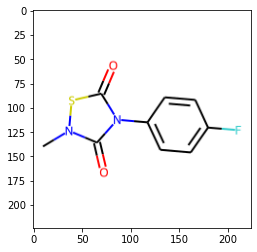

In [83]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(images[0])
imgplot = plt.imshow(img)
plt.show()

# Create train validation split

In [84]:
from sklearn.model_selection import train_test_split

In [85]:
x_train, x_valid = train_test_split(df.index, test_size=0.2, random_state=666, stratify=df['Activity'])
df.loc[x_train, 'is_valid']=False
df.loc[x_valid, 'is_valid']=True

In [86]:
df.is_valid.value_counts()

False    14352
True      3589
Name: is_valid, dtype: int64

# Create dataloader

In [87]:
from fastai.vision.all import *

In [88]:
df['Image'] = df['CID'] + '.png'
df.head()

,CID,SMILES,Activity,is_valid,Image
0,CHEMBL188002,S(=O)(=O)(N)c1cc(N/C(/S)=N\c2cc(C(=O)[O-])c(cc2)C=2c3c(OC4=CC(=O)C=CC=24)cc(O)cc3)ccc1,1,False,CHEMBL188002.png
1,CHEMBL364127,Clc1ccc(cc1)C(=O)NC1Cc2cc(S(=O)(=O)N)ccc2C1,1,False,CHEMBL364127.png
2,CHEMBL1683469,S(=O)(=O)(N)c1ccc(cc1)CNS(=O)(=O)CC12CCC(CC1=O)C2(C)C,1,False,CHEMBL1683469.png
3,CHEMBL52564,Oc1ccccc1\C=C\C(=O)[O-],1,False,CHEMBL52564.png
4,CHEMBL21427,OB(O)c1ccc(OC)cc1,1,False,CHEMBL21427.png


In [89]:
images = df['CID'] + ".png"
images.head()

0     CHEMBL188002.png
1     CHEMBL364127.png
2    CHEMBL1683469.png
3      CHEMBL52564.png
4      CHEMBL21427.png
Name: CID, dtype: object

In [90]:
db = DataBlock(
    blocks = (ImageBlock(), CategoryBlock()), 
    get_x=ColReader('Image', pref=IMAGES),
    get_y=ColReader('Activity'), 
    splitter=ColSplitter('is_valid'),
    item_tfms=None, 
    batch_tfms=None
    )

In [91]:
dls = db.dataloaders(df, bs=64, shuffle_train=True)

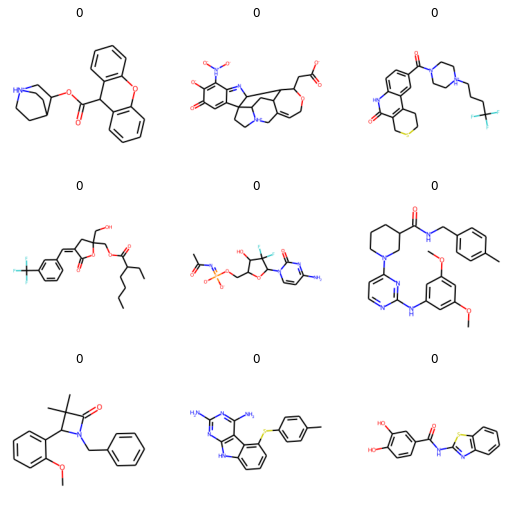

In [92]:
dls.show_batch()

# Train CNN model

In [93]:
from sklearn.metrics import auc,roc_auc_score,recall_score,precision_score,f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score

In [94]:
def train_model(dls, arch=resnet18, epochs=6, freeze_epochs=5, wd=None):
    
    print(f'Training model on dataset: {dataset}')
    print(f'Architechture: {arch}')
    print(f'Untrained epochs: freeze_epochs={freeze_epochs}')
    print(f'Trained epochs: epochs={epochs}')
    
    learn = cnn_learner(dls, arch=resnet18, pretrained=True, 
                            wd=wd,
                            metrics=[accuracy, 
                            F1Score(), 
                            Precision(), 
                            Recall(), 
                            RocAucBinary(), 
                            MatthewsCorrCoef()])
    
    
    print(f'Finding learning rate...')
    lr_min, lr_steep = learn.lr_find(suggestions=True, show_plot=False)
    print(f'Training model with learning rate: {lr_min}')
    learn.fine_tune(epochs, lr_min, freeze_epochs=freeze_epochs)
    
    return learn

In [95]:
# Train model on resnet18
learn = train_model(dls, epochs=6, freeze_epochs=0, wd=2e-4)

Training model on dataset: CHEMBL205_cl
Architechture: <function resnet18 at 0x7f68043458b0>
Untrained epochs: freeze_epochs=0
Trained epochs: epochs=6
Finding learning rate...


Training model with learning rate: 0.017378008365631102


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.186535,0.144452,0.947618,0.632812,0.870968,0.496933,0.944797,0.634675,00:54
1,0.158604,0.263344,0.909167,0.000000,0.000000,0.000000,0.958180,0.000000,00:55
2,0.135845,0.146966,0.948732,0.754011,0.668246,0.865031,0.960853,0.733458,00:53
3,0.107818,0.148757,0.962106,0.786164,0.806452,0.766871,0.951311,0.765681,00:54
4,0.077988,0.093993,0.965729,0.801292,0.846416,0.760736,0.981459,0.783933,00:47
5,0.043451,0.096992,0.970744,0.835165,0.855305,0.815951,0.982547,0.819396,00:44


/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [67]:
# Train on resnet34
learn = train_model(dls, arch=resnet34)

Training model on dataset: CHEMBL218_cl
Architechture: <function resnet34 at 0x7f6804345940>
Untrained epochs: freeze_epochs=5
Trained epochs: epochs=6
Finding learning rate...


Training model with learning rate: 0.012022644281387329


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.325150,0.207611,0.923059,0.562500,0.584746,0.541885,0.900339,0.520840,00:40
1,0.197992,0.160940,0.941219,0.620370,0.755639,0.526178,0.936084,0.600977,00:39
2,0.190611,0.155792,0.947670,0.683983,0.762058,0.620419,0.943579,0.659904,00:39
3,0.154270,0.132965,0.954839,0.732673,0.796923,0.678010,0.966055,0.710943,00:40
4,0.117002,0.126390,0.964397,0.791024,0.851964,0.738220,0.967272,0.774041,00:39


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.129669,0.135288,0.957945,0.717042,0.929167,0.583770,0.971710,0.717578,00:50
1,0.101529,0.184823,0.928315,0.678801,0.574275,0.829843,0.956202,0.653705,00:50
2,0.078848,0.101392,0.969654,0.813510,0.926421,0.725131,0.978313,0.804351,00:50
3,0.034458,0.080772,0.979450,0.886544,0.893617,0.879581,0.982232,0.875280,00:50
4,0.011494,0.096195,0.984229,0.911290,0.936464,0.887435,0.981222,0.903036,00:50
5,0.004576,0.094186,0.985424,0.917679,0.947075,0.890052,0.982487,0.910219,00:51


In [72]:
interp = ClassificationInterpretation.from_learner(learn)

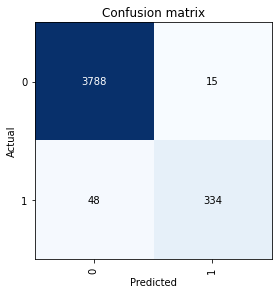

In [73]:
interp.plot_confusion_matrix()

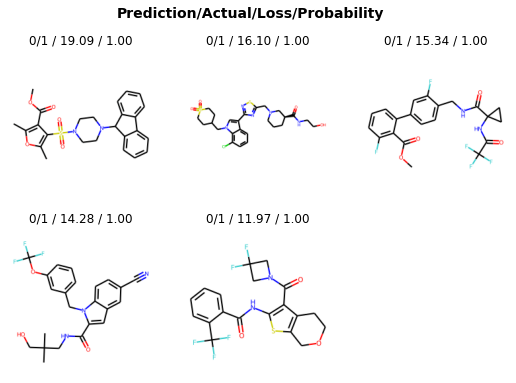

In [74]:
interp.plot_top_losses(k=5)

# Hook the activations from the second last layer

In [75]:
layers = flatten_model(learn.model)
len(layers)

60

In [76]:
layers[-10:-5]

[AdaptiveAvgPool2d(output_size=1),
 AdaptiveMaxPool2d(output_size=1),
 Flatten(full=False),
 BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 Dropout(p=0.25, inplace=False)]